# Homework 2

## FINM 25000 - 2025

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

## HBS Case

### *ProShares Hedge Replication ETF*

***

# 1. The ProShares ETF Product

**Section 1 is not graded**, and you do not need to submit your answers. But you are encouraged to think about them, and we will discuss them.

## 1. Alternative ETFs

Describe the two types of investments referenced by this term.

## 2. Hedge Funds.


* a. Using just the information in the case, what are two measures by which hedge funds are an attractive investment?
  - ??

* b. What are the main benefits of investing in hedge funds via an ETF instead of directly?
  - you can see real time value?

## 3. The Benchmarks

* a. Explain as simply as possible how HFRI, MLFM, MLFM-ES, and HDG differ in their construction and purpose.


* b. How well does the Merrill Lynch Factor Model (MLFM) track the HFRI?

* c. In which factor does the MLFM have the largest loading? (See a slide in Exhibit 1.)


* d. What are the main concerns you have for how the MLFM attempts to replicate the HFRI?


## 4. The HDG Product

* a. What does ProShares ETF, HDG, attempt to track? Is the tracking error small?

* b. HDG is, by construction, delivering beta for investors. Isn't the point of hedge funds to generate alpha? Then why would HDG be valuable?

* c. The fees of a typical hedge-fund are 2% on total assets plus 20% of excess returns if positive. HDG's expense ratio is roughly 1% on total assets. What would their respective net Sharpe Ratios be, assuming both have a gross excess returns of 10% and volatility of 20%?

***

# 2.  Analyzing the Data

Use the data found on Canvas, in <b>'proshares analysis data.xlsx'</b>. 

It has monthly data on financial indexes and ETFs from `Aug 2011` through `May 2025`.

## 1. 

For the series in the "hedge fund series" tab, report the following summary statistics:
* mean
* volatility
* Sharpe ratio

Annualize these statistics.

In [77]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

In [71]:
'''
import series/data freme from excel
- easy
- apply formatting to find date column
- look at TA's notes 
'''

hedge_fund = pd.read_excel(io = '../data/proshares_analysis_data.xlsx',
                   sheet_name = 'hedge_fund_series',
                   index_col=0,
                   date_format=[0])

summary = {}
summary['Annualized mean'] = hedge_fund.mean() * 12
summary['Annualized vol'] = hedge_fund.std() * 12**0.5
summary['Annualized sharpe'] = summary['Annualized mean'] /  \
                               summary['Annualized vol']
hedge_fund_yr = pd.DataFrame(summary)

## 2.

For the series in the "hedge fund series" tab, calculate the following statistics related to tail-risk.
* Skewness
* Excess Kurtosis (in excess of 3)
* VaR (.05) - the fifth quantile of historic returns
* CVaR (.05) - the mean of the returns at or below the fifth quantile
* Maximum drawdown - include the dates of the max/min/recovery within the max drawdown period.

There is no need to annualize any of these statistics.

In [ ]:
# from last year pset
stats = {}
stats['skewness'] = hedge_fund.skew()
stats['excess kurtosis'] = hedge_fund.kurtosis()
stats['VaR 5%'] = hedge_fund.quantile(0.05, axis=0) #what does axis do
stats['CVaR <5%'] = hedge_fund[hedge_fund <= hedge_fund.quantile(0.05, axis=0)].mean() #how this work

# Cumulative returns on $1000
wealth_index = 1000 * (1 + hedge_fund).cumprod()

previous_peaks = wealth_index.cummax()

# Biggest difference between cumulative max and your current wealth
drawdowns = (wealth_index - previous_peaks) / previous_peaks

stats["Max Drawdown"] = drawdowns.min()
stats["Peak"] = previous_peaks.idxmax()
stats["Bottom"] = drawdowns.idxmin()

# just ripping from sol 2 from last year pset, could not figure it out myself
recovery_date = []
for col in wealth_index.columns:
    prev_max = previous_peaks[col][: drawdowns[col].idxmin()].max()
    recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin() :]]).T
    recovery_date.append(
        recovery_wealth[recovery_wealth[col] >= prev_max].index.min()
    )

# Here, we use a list comprehension to check if the recovery date is null,
# meaning that the drawdown has not yet recovered.
stats["Recovery"] = ["-" if pd.isnull(i) else i for i in recovery_date]

pd.DataFrame(stats)

,skewness,excess kurtosis,VaR 5%,CVaR <5%,Max Drawdown,Peak,Bottom,Recovery
HFRIFWI Index,-0.979063,5.955123,-0.025324,-0.037478,-0.115473,2021-10-31,2020-03-31,2020-08-31 00:00:00
MLEIFCTR Index,-0.244981,1.689648,-0.028764,-0.035857,-0.124302,2021-06-30,2022-09-30,-
MLEIFCTX Index,-0.231032,1.657903,-0.029119,-0.035816,-0.124388,2021-06-30,2022-09-30,-
HDG US Equity,-0.233880,1.799098,-0.031209,-0.037577,-0.140721,2021-06-30,2022-09-30,-
QAI US Equity,-0.461338,1.825993,-0.020593,-0.032695,-0.137712,2021-06-30,2022-09-30,-


## 3. 

For the series in the "hedge fund series" tab, run a regression of each against SPY (found in the "merrill factors" tab.) Include an intercept. Report the following regression-based statistics:
* Market Beta
* Treynor Ratio
* Information ratio

Annualize these three statistics as appropriate.

In [73]:
spy: Series = pd.read_excel(io = '../data/proshares_analysis_data.xlsx',
                   sheet_name = 'merrill_factors',
                   index_col=0,
                   date_format=[0])['SPY US Equity']

betas = {}
TRs = {}
IRs = {} # Ahhh the IRS

# iterate through assets names i (str) and annualize
for i in hedge_fund.columns:
    reg_i = sm.OLS(hedge_fund[i], sm.add_constant(spy)).fit()
    betas[i] = reg_i.params['SPY US Equity']
    TRs[i] = hedge_fund[i].mean() * 12 / betas[i]
    IRs[i] = reg_i.params['const'] / reg_i.resid.std() * 12**0.5

# compile to dataframe
risks = {}
risks['beta'] = betas
risks['TR'] = TRs
risks['IRs'] = IRs
risks_df = pd.DataFrame(risks) # LEARNED easier way to get dataframe
risks_df

,beta,TR,IRs
HFRIFWI Index,0.348217,0.119027,-0.109520
MLEIFCTR Index,0.349859,0.087664,-0.571877
MLEIFCTX Index,0.348514,0.083896,-0.620547
HDG US Equity,0.359536,0.054075,-0.964387
QAI US Equity,0.294096,0.057662,-0.832728


In [74]:
# personal helper function for visualizing the linear reg
def quick_plot(sm_reg, x: pd.Series, y: pd.Series, x_name = 'SPY US Equity'):
    x_values = np.linspace(x.min(), x.max())
    y_values = sm_reg.params['const'] + sm_reg.params[x_name] * x_values
    plt.scatter(x, y, alpha = 0.6, label="data")
    plt.plot(x_values, y_values, color='red', label='reg line')

    plt.xlabel("SPY Returns")
    plt.ylabel("Asset Returns")
    plt.title("Linear Regression: Asset ~ SPY")
    plt.legend()
    plt.show()
    # chatgpt helped in writing this func

## 4. 

Discuss the previous statistics
 * beta's tell us for 1% return in market, x return in asset
 * TR's tell us return-risk of asset return / market exposure (risk)
 * IR's tell us sharpe ratio of returns unattributed to market (including noise in data)

and what they tell us about...
* the differences between SPY and the hedge-fund series?
    * is the hedge-fund series HRFI?
    * roughly 1/3 of growth in hedge-fund series is explained by market. The low TR ratio indicates relatively high market risk in asset. IRs tell me that series typically has negative returns, excluding returns associated with market 
* which performs better between HDG and QAI.
    * I think QAI performs better higher TR that it can have higher returns for same market risk. 
* whether HDG and the ML series capture the most notable properties of HFRI.
    * the ML series seems to have the most similar beta TR and IR to HRFI

## 5. 

Report the correlation matrix for these assets.
* Show the correlations as a heat map.
* Which series have the highest and lowest correlations?

<Axes: >

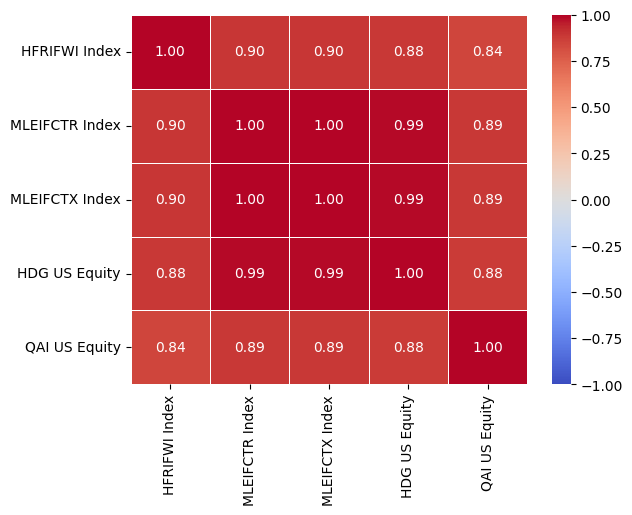

In [82]:
# from TA Review 1
def plot_corr_matrix(corrs):
    return sns.heatmap(
        corrs,  # The correlation matrix
        annot=True,  # Annot means include the correlation values in the heatmap
        cmap="coolwarm",  # The color scheme to use
        vmin=-1,
        vmax=1,  # Specify the max and min values for the color scheme, otherwise they will
        # be set to the min and max values of the correlation matrix, which is not
        # particularly useful.
        linewidths=0.7,  # The width of the lines that will divide each cell, mainly an aesthetic choice,
        # but it does make the heatmap easier to read.
        annot_kws={
            "size": 10
        },  # Specify the size of the annotation text to avoid overflow into adjacent cells.
        fmt=".2f",  # Specify the format of the annotation text, in this case, we want to round to 2 decimal places.
        # See: https://kuvapcsitrd01.kutztown.edu/~schwesin/fall20/csc223/lectures/Python_String_Formatting.html
    )

corr_matrix = hedge_fund.corr()
plot_corr_matrix(corr_matrix)

- highest correlation of ~1 for the two ML series
- loweest correlation of 0.84 for QAI and HFRIFWI 

## 6.

Replicate HFRI with the six factors listed on the "merrill factors" tab. Include a constant, and run the unrestricted regression,

$\newcommand{\hfri}{\text{hfri}}$
$\newcommand{\merr}{\text{merr}}$

$$\begin{align}
r^{\hfri}_{t} &= \alpha^{\merr} + x_{t}^{\merr}\beta^{\merr} + \epsilon_{t}^{\merr}\\[5pt]
\hat{r}^{\hfri}_{t} &= \hat{\alpha}^{\merr} + x_{t}^{\merr}\hat{\beta}^{\merr}
\end{align}$$

Note that the second equation is just our notation for the fitted replication.

a. Report the intercept and betas.

b. Are the betas realistic position sizes, or do they require huge long-short positions?

c. Report the R-squared.

d. Report the volatility of $\epsilon^{\merr}$, the tracking error.

In [ ]:
mer_factors: pd.DataFrame = pd.read_excel(io = '../data/proshares_analysis_data.xlsx',
                   sheet_name = 'merrill_factors',
                   index_col=0,
                   date_format=[0])

X_mer: pd.DataFrame = sm.add_constant(mer_factors)
y_mer: pd.DataFrame = hedge_fund['HFRIFWI Index']
mer_reg = sm.OLS(y_mer, X_mer).fit()

print('a.')
print("intercept:", mer_reg.params['const'])
for i in mer_factors.columns:
    print(i, "beta:", mer_reg.params[i])


a.
intercept: 0.001482858667677645
SPY US Equity beta: 0.02996270987668183
USGG3M Index beta: -0.3709145694289558
EEM US Equity beta: 0.07911798262686853
EFA US Equity beta: 0.0841610080393073
EUO US Equity beta: 0.023105820542603815
IWM US Equity beta: 0.15329353460053724


b. ???????

In [103]:
print("c. r-squared:", mer_reg.rsquared)
print("d. volatility of tracking error:", mer_reg.resid.std())

c. r-squared: 0.8360581565663838
d. volatility of tracking error: 0.007061704056747993


## 7.

Let's examine the replication out-of-sample (OOS).

Starting with $t = 61$ month of the sample, do the following:

* Use the previous 60 months of data to estimate the regression equation. 
This gives time-t estimates of the regression parameters, $\tilde{\alpha}^{\merr}_{t}$ and $\tilde{\beta}^{\merr}_{t}$.

* Use the estimated regression parameters, along with the time-t regressor values, $x^{\merr}_{t}$, calculate the time-t replication value that is, with respect to the regression estimate, built "out-of-sample" (OOS).

$$\hat{r}^{\hfri}_{t} \equiv \tilde{\alpha}^{\merr} + (x_{t}^{\merr})'\tilde{\beta}^{\merr}$$

* Step forward to $t = 62$, and now use $t = 2$ through $t = 61$ for the estimation. Re-run the steps above, and continue this process throughout the data series. Thus, we are running a rolling, 60-month regression for each point-in-time.

How well does the out-of-sample replication perform with respect to the target?

***

# 3.  Extensions
<i>**This section is not graded, and you do not need to submit it.** Still, we may discuss it in class some extensions in class.

For those looking for a challenge, try a few of these.

## 1. 

Merrill constrains the weights of each asset in its replication regression of HFRI. Try constraining your weights by re-doing 2.6.

* Use Non-Negative Least Squares (NNLS) instead of OLS.
* Go further by using a Generalized Linear Model to put separate interval constraints on each beta, rather than simply constraining them to be non-negative.

#### Hints
* Try using LinearRegression in scikit-learn with the parameter `positive=True`. 
* Try using GLM in statsmodels.

## 2. 

Let's decompose a few other targets to see if they behave as their name suggests.

* Regress HEFA on the same style factors used to decompose HFRI. Does HEFA appear to be a currency-hedged version of EFA?

* Decompose TRVCI with the same style factors used to decompose HFRI. The TRVCI Index tracks venture capital funds--in terms of our styles, what best describes venture capital?

* TAIL is an ETF that tracks SPY, but that also buys put options to protect against market downturns. Calculate the statistics in questions 2.1-2.3 for TAIL. Does it seem to behave as indicated by this description? That is, does it have high correlation to SPY while delivering lower tail risk?

## 3. 

The ProShares case introduces Levered ETFs. ProShares made much of its name originally through levered, or "geared" ETFs.

Explain conceptually why Levered ETFs may track their index well for a given day but diverge over time. How is this exacerbated in volatile periods like 2008?

## 4.

Analyze SPXU and UPRO relative to SPY.
- SPXU is ProShares -3x SPX ETF.
- UPRO is ProShres +3x SPX ETF.

Questions:
* Analyze them with the statistics from 2.1-2.3. 

* Do these two ETFs seem to live up to their names?

* Plot the cumulative returns of both these ETFs along with SPY.

* What do you conclude about levered ETFs?

## 5.

In `Section 2`, we estimated the replications using an intercept. Try the full-sample estimation, but this time without an intercept.

$$\begin{align}
r^{\hfri}_{t} &= \alpha^{merr} + x_{t}^{\merr}\beta^{\merr} + \epsilon_{t}^{\merr}\\[5pt]
\check{r}^{\hfri}_{t} &= \check{\alpha}^{\merr} + x_{t}^{\merr}\check{\beta}^{\merr}
\end{align}$$

Report

* the regression beta. How does it compare to the estimated beta with an intercept, $\hat{\beta}^{\merr}$?

* the mean of the fitted value, $\check{r}^{\hfri}_{t}$. How does it compare to the mean of the HFRI?

* the correlations of the fitted values, $\check{r}^{\hfri}_{t}$ to the HFRI. How does the correlation compare to that of the fitted values with an intercept, $\hat{r}^{\hfri}_{t}$

Do you think Merrill and ProShares fit their replicators with an intercept or not?

***